# 03. Building Workflows with LangGraph

## 安装依赖

In [1]:
%uv pip install langchain~=0.3 langchain-core~=0.3 langchain-openai~=0.3 langgraph==0.6.7

Resolved 42 packages in 456ms                                        
⠙ Preparing packages... (0/1)                                                   
⠙ Preparing packages... (0/1)--------------     0 B/149.74 KiB          
⠹ Preparing packages... (0/1)-------------- 16.00 KiB/149.74 KiB        
⠹ Preparing packages... (0/1)-------------- 16.00 KiB/149.74 KiB        
⠹ Preparing packages... (0/1)-------------- 32.00 KiB/149.74 KiB        
⠹ Preparing packages... (0/1)-------------- 48.00 KiB/149.74 KiB        
⠹ Preparing packages... (0/1)-------------- 62.80 KiB/149.74 KiB        
⠸ Preparing packages... (0/1)-------------- 78.80 KiB/149.74 KiB        
⠸ Preparing packages... (0/1)-------------- 78.80 KiB/149.74 KiB        
⠸ Preparing packages... (0/1)----------- 94.80 KiB/149.74 KiB        
⠸ Preparing packages... (0/1)---------- 110.80 KiB/149.74 KiB       
⠸ Preparing packages... (0/1)---------- 126.80 KiB/149.74 KiB       
⠸ Preparing packages... (0/1)---------- 142.80 KiB/149.74

In [2]:
%uv pip install  python-dotenv~=1.1

Resolved 1 package in 46ms                                           
░░░░░░░░░░░░░░░░░░░░ [0/1] Installing wheels...                                 warning: Failed to hardlink files; falling back to full copy. This may lead to degraded performance.
         If the cache and target directories are on different filesystems, hardlinking may not be supported.
         If this is intentional, set `export UV_LINK_MODE=copy` or use `--link-mode=copy` to suppress this warning.
Installed 1 package in 21ms                                 
 + python-dotenv==1.2.1
Note: you may need to restart the kernel to use updated packages.


工具类

In [3]:
import os

import dotenv
from langchain_openai import ChatOpenAI


class Config:
    def __init__(self):
        # By default, load_dotenv doesn't override existing environment variables and looks for a .env file in same directory as python script or searches for it incrementally higher up.
        dotenv_path = dotenv.find_dotenv(usecwd=True)
        if not dotenv_path:
            raise ValueError("No .env file found")
        dotenv.load_dotenv(dotenv_path=dotenv_path)

        api_key = os.getenv("OPENAI_API_KEY")
        if not api_key:
            raise ValueError("OPENAI_API_KEY is not set")

        base_url = os.getenv("OPENAI_API_BASE_URL")
        if not base_url:
            raise ValueError("OPENAI_API_BASE_URL is not set")

        model = os.getenv("OPENAI_MODEL")
        if not model:
            raise ValueError("OPENAI_MODEL is not set")

        vl_model = os.getenv("OPENAI_VL_MODEL")

        self.api_key = api_key
        self.base_url = base_url
        self.model = model
        self.vl_model = vl_model

    def new_openai_like(self, **kwargs) -> ChatOpenAI:
        # 参考：https://bailian.console.aliyun.com/?tab=api#/api/?type=model&url=2587654
        # 参考：https://help.aliyun.com/zh/model-studio/models
        # ChatOpenAI 文档参考：https://python.langchain.com/api_reference/openai/chat_models/langchain_openai.chat_models.base.ChatOpenAI.html#langchain_openai.chat_models.base.ChatOpenAI
        return ChatOpenAI(
            api_key=self.api_key, base_url=self.base_url, model=self.model, **kwargs
        )

    def new_openai_like_vl(self, **kwargs) -> ChatOpenAI:
        if not self.vl_model:
            raise ValueError("OPENAI_VL_MODEL is not set")

        # 参考：https://bailian.console.aliyun.com/?tab=api#/api/?type=model&url=2587654
        # 参考：https://help.aliyun.com/zh/model-studio/models
        # ChatOpenAI 文档参考：https://python.langchain.com/api_reference/openai/chat_models/langchain_openai.chat_models.base.ChatOpenAI.html#langchain_openai.chat_models.base.ChatOpenAI
        return ChatOpenAI(
            api_key=self.api_key, base_url=self.base_url, model=self.vl_model, **kwargs
        )

## LangGraph fundamentals

### State management

In [2]:
from typing_extensions import TypedDict


class JobApplicationState(TypedDict):
    job_description: str
    is_suitable: bool
    application: str

In [3]:
from langgraph.graph import StateGraph, START, END


def analyze_job_description(state):
    print("...Analyzing a provided job description ...")
    return {"is_suitable": len(state["job_description"]) > 100}


def generate_application(state):
    print("...generating application...")
    return {"application": "some_fake_application"}


builder = StateGraph(JobApplicationState)
builder.add_node("analyze_job_description", analyze_job_description)
builder.add_node("generate_application", generate_application)

builder.add_edge(START, "analyze_job_description")
builder.add_edge("analyze_job_description", "generate_application")
builder.add_edge("generate_application", END)

graph = builder.compile()

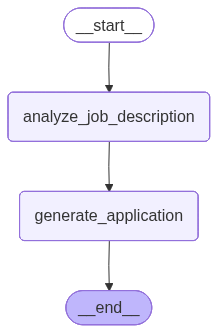

In [4]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [5]:
graph.invoke({"job_description": "fake_jd"})

...Analyzing a provided job description ...
...generating application...


{'job_description': 'fake_jd',
 'is_suitable': False,
 'application': 'some_fake_application'}

In [6]:
from typing import Literal

builder = StateGraph(JobApplicationState)
builder.add_node("analyze_job_description", analyze_job_description)
builder.add_node("generate_application", generate_application)


def is_suitable_condition(
    state: JobApplicationState,
) -> Literal["generate_application", END]:
    if state.get("is_suitable"):
        return "generate_application"
    return END


builder.add_edge(START, "analyze_job_description")
builder.add_conditional_edges("analyze_job_description", is_suitable_condition)
builder.add_edge("generate_application", END)

graph = builder.compile()

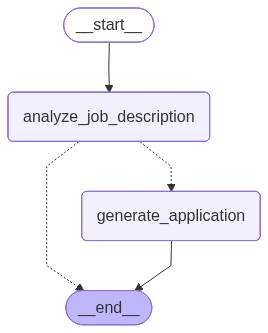

In [7]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

### Reducers

#### Option 1

In [8]:
class JobApplicationState(TypedDict):
    job_description: str
    is_suitable: bool
    application: str
    actions: list[str]


def analyze_job_description(state):
    print("...Analyzing a provided job description ...")
    result = {
        "is_suitable": len(state["job_description"]) < 100,
        "actions": ["action1"],
    }
    return result


def generate_application(state):
    print("...generating application...")
    return {"application": "some_fake_application", "actions": ["action2"]}


builder = StateGraph(JobApplicationState)
builder.add_node("analyze_job_description", analyze_job_description)
builder.add_node("generate_application", generate_application)
builder.add_edge(START, "analyze_job_description")
builder.add_conditional_edges("analyze_job_description", is_suitable_condition)
builder.add_edge("generate_application", END)

graph = builder.compile()

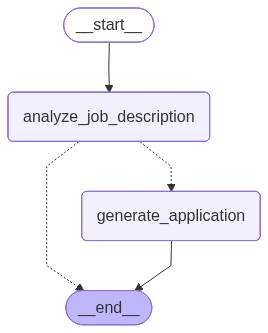

In [9]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
async for chunk in graph.astream(
    input={"job_description": "fake_jd"}, stream_mode="values"
):
    print(chunk)
    print("\n\n")

{'job_description': 'fake_jd'}



...Analyzing a provided job description ...
{'job_description': 'fake_jd', 'is_suitable': True, 'actions': ['action1']}



...generating application...
{'job_description': 'fake_jd', 'is_suitable': True, 'application': 'some_fake_application', 'actions': ['action2']}





#### Option 2 - use `add` method as a reducer

In [11]:
from typing import Annotated
from operator import add


class JobApplicationState(TypedDict):
    job_description: str
    is_suitable: bool
    application: str
    actions: Annotated[list[str], add]


def analyze_job_description(state):
    print("...Analyzing a provided job description ...")
    result = {
        "is_suitable": len(state["job_description"]) < 100,
        "actions": ["action1"],
    }
    return result


def generate_application(state):
    print("...generating application...")
    return {"application": "some_fake_application", "actions": ["action2"]}


builder = StateGraph(JobApplicationState)

builder.add_node("analyze_job_description", analyze_job_description)
builder.add_node("generate_application", generate_application)

builder.add_edge(START, "analyze_job_description")
builder.add_conditional_edges("analyze_job_description", is_suitable_condition)
builder.add_edge("generate_application", END)

graph = builder.compile()

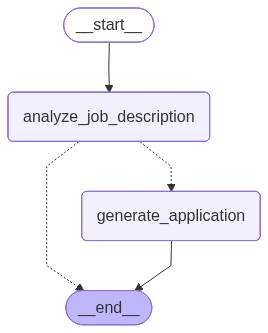

In [12]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [13]:
async for chunk in graph.astream(
    input={"job_description": "fake_jd"}, stream_mode="values"
):
    print(chunk)
    print("\n\n")

{'job_description': 'fake_jd', 'actions': []}



...Analyzing a provided job description ...
{'job_description': 'fake_jd', 'is_suitable': True, 'actions': ['action1']}



...generating application...
{'job_description': 'fake_jd', 'is_suitable': True, 'application': 'some_fake_application', 'actions': ['action1', 'action2']}





#### Option 3 - customize reducer

In [ ]:
from typing import Annotated


def my_reducer(left: list[str], right: str | list[str] | None = None) -> list[str]:
    if right:
        return left + [right] if isinstance(right, str) else left + right
    return left


class JobApplicationState(TypedDict):
    job_description: str
    is_suitable: bool
    application: str
    actions: Annotated[list[str], my_reducer]


def analyze_job_description(state):
    print("...Analyzing a provided job description ...")
    result = {"is_suitable": len(state["job_description"]) < 100, "actions": "action1"}
    return result


def generate_application(state):
    print("...generating application...")
    return {"application": "some_fake_application", "actions": ["action2", "action3"]}


builder = StateGraph(JobApplicationState)

builder.add_node("analyze_job_description", analyze_job_description)
builder.add_node("generate_application", generate_application)

builder.add_edge(START, "analyze_job_description")
builder.add_conditional_edges("analyze_job_description", is_suitable_condition)
builder.add_edge("generate_application", END)

graph = builder.compile()

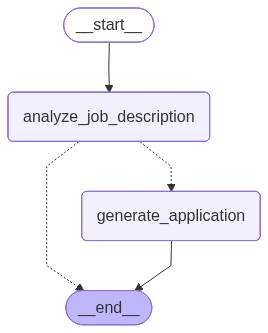

In [15]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [16]:
async for chunk in graph.astream(
    input={"job_description": "fake_jd"}, stream_mode="values"
):
    print(chunk)
    print("\n\n")

{'job_description': 'fake_jd', 'actions': []}



...Analyzing a provided job description ...
{'job_description': 'fake_jd', 'is_suitable': True, 'actions': ['action1']}



...generating application...
{'job_description': 'fake_jd', 'is_suitable': True, 'application': 'some_fake_application', 'actions': ['action1', 'action2', 'action3']}





### Making graphs configurable

In [17]:
from langchain_core.runnables.config import RunnableConfig


def generate_application(state: JobApplicationState, config: RunnableConfig):
    model_provider = config["configurable"].get("model_provider", "Google")
    model_name = config["configurable"].get("model_name", "gemini-2.0-flash")
    print(f"...generating application with {model_provider} and {model_name} ...")
    return {"application": "some_fake_application", "actions": ["action2", "action3"]}


builder = StateGraph(JobApplicationState)

builder.add_node("analyze_job_description", analyze_job_description)
builder.add_node("generate_application", generate_application)

builder.add_edge(START, "analyze_job_description")
builder.add_conditional_edges("analyze_job_description", is_suitable_condition)
builder.add_edge("generate_application", END)

graph = builder.compile()

In [18]:
graph.invoke(
    {"job_description": "fake_jd"},
    config={"configurable": {"model_provider": "OpenAI", "model_name": "gpt-4o"}},
)

...Analyzing a provided job description ...
...generating application with OpenAI and gpt-4o ...


{'job_description': 'fake_jd',
 'is_suitable': True,
 'application': 'some_fake_application',
 'actions': ['action1', 'action2', 'action3']}

### Controlled output generation
#### Output parsing

In [6]:
job_description = """
SPS-Software Engineer (m/w/d) im Maschinenbau
Glaston Germany GmbH
Neuhausen-Hamberg
Feste Anstellung
Homeoffice möglich, Vollzeit
Erschienen: vor 1 Tag
Glaston Germany GmbH logo
SPS-Software Engineer (m/w/d) im Maschinenbau
Glaston Germany GmbH
slide number 1slide number 2slide number 3
Glaston ist eine internationale Marke mit weltweit führenden Unternehmen, die für zukunftsweisende Maschinen, Anlagen, Systeme und Dienstleistungen in der Bearbeitung von Architektur-, Fahrzeug- und Displayglas steht.

Mit unserer über 50-jährigen Erfahrung am Standort Glaston Germany GmbH in Neuhausen bei Pforzheim verbessern und sichern wir nachhaltig die Produktivität unserer Kunden bei der Fertigung von Architekturglas. Diesen Erfolg verdanken wir unseren motivierten und engagierten Mitarbeitenden und wurden so zu einem der führenden Anbieter von automatisierten und kundenspezifischen Anlagen.

Der Umgang mit Software liegt dir im Blut und du möchtest bei einem Hidden Champion durchstarten?
Dein Faible für Softwarelösungen und dein Herz für unterschiedliche Technologien sind ideale Voraussetzungen, um Maschinen wieder zu alter Stärke zu verhelfen?
Du hast einen ausgeprägten Servicegedanken und Spaß an der Arbeit mit Kunden?

Dann komm zu Glaston! Wir suchen ab sofort für unseren Bereich Service Upgrades Verstärkung!

SPS-SOFTWARE ENGINEER (M/W/D) IM MASCHINENBAU

Als SPS-Software Engineer (m/w/d) im Maschinenbau sind deine Aufgabengebiete:
Ausarbeitung und Weiterentwicklung von Kundenaufträgen und Upgrade-Konzepten
Selbstständige und termingerechte Bearbeitung von Kundenprojekten und Bereitstellung der notwendigen Dokumente
Unterstützung des Inbetriebnahme- und Servicepersonals im Haus und beim Kunden vor Ort
Diese Anforderungen musst du mitbringen:
Qualifizierte technische Ausbildung: Techniker, Studium oder vergleichbare Qualifikation
Mehrjährige Berufserfahrung im Serviceumfeld, idealerweise im Maschinen- und Anlagenbau
Umfangreiche Kenntnisse in verschiedenen SPS-Programmiersprachen (z.B. S7Classic, TIA, Simotion)
Bei uns profitierst du von folgenden Benefits:
Exzellente Rahmenbedingungen (z.B. attraktives Gehaltsmodell, flexible Arbeitszeiten mit Gleitzeit und Homeoffice-Möglichkeiten)
Attraktives Arbeitsumfeld in idyllisch-ländlicher Lage
Umfangreiche Mobilitätsförderung (z.B. Ladestation für Elektroautos)
Wellbeing am Arbeitsplatz
"""

In [3]:
llm = Config().new_openai_like()

prompt_template = (
    "Given a job description, decide whether it suites a junior Java developer."
    "\nJOB DESCRIPTION:\n{job_description}\n"
)

llm.invoke(prompt_template.format(job_description=job_description))

AIMessage(content='No, this job description is **not suitable for a junior Java developer**.\n\nHere’s why:\n\n### 1. **Domain Mismatch**\n- The role is for an **SPS-Software Engineer in mechanical engineering (Maschinenbau)**.\n- "SPS" stands for *Speicherprogrammierbare Steuerung* (Programmable Logic Controller or PLC in English), which is used in industrial automation—not general-purpose software development.\n- The required programming languages are **PLC-specific**: S7Classic, TIA Portal, Simotion—**not Java**.\n\n### 2. **Required Experience Level**\n- The job explicitly asks for **"mehrjährige Berufserfahrung"** (several years of professional experience), especially in a **service environment within mechanical and plant engineering**.\n- This indicates a **mid- to senior-level role**, not an entry-level or junior position.\n\n### 3. **Technical Skills Focus**\n- The core competencies are in **industrial automation, PLC programming, and on-site machine servicing**—not in Java, we

In [4]:
prompt_template_enum = (
    "Given a job description, decide whether it suites a junior Java developer."
    "\nJOB DESCRIPTION:\n{job_description}\n\nAnswer only YES or NO."
)
result = llm.invoke(prompt_template_enum.format(job_description=job_description))

result.content

'NO'

Out-of-box parser from LangChain

In [5]:
from enum import Enum
from langchain.output_parsers import EnumOutputParser
from langchain_core.messages import HumanMessage


class IsSuitableJobEnum(Enum):
    YES = "YES"
    NO = "NO"


parser = EnumOutputParser(enum=IsSuitableJobEnum)

assert parser.invoke("NO") == IsSuitableJobEnum.NO
assert parser.invoke("YES\n") == IsSuitableJobEnum.YES
assert parser.invoke(" YES \n") == IsSuitableJobEnum.YES
assert parser.invoke(HumanMessage(content=" YES \n")) == IsSuitableJobEnum.YES

In [6]:
chain = llm | parser

chain.invoke(prompt_template_enum.format(job_description=job_description))

<IsSuitableJobEnum.NO: 'NO'>

In [ ]:
from typing_extensions import TypedDict
from langchain_core.runnables.config import RunnableConfig
from langgraph.graph import StateGraph, START, END


class JobApplicationState(TypedDict):
    job_description: str
    is_suitable: IsSuitableJobEnum
    application: str


analyze_chain = llm | parser


def analyze_job_description(state):
    job_description = state["job_description"]
    prompt = prompt_template_enum.format(job_description=job_description)
    result = analyze_chain.invoke(prompt)
    return {"is_suitable": result}


def is_suitable_condition(state: JobApplicationState):
    return state["is_suitable"] == IsSuitableJobEnum.YES


def generate_application(state):
    print("...generating application...")
    return {"application": "some_fake_application", "actions": ["action2"]}


builder = StateGraph(JobApplicationState)

builder.add_node("analyze_job_description", analyze_job_description)
builder.add_node("generate_application", generate_application)

builder.add_edge(START, "analyze_job_description")
builder.add_conditional_edges(
    "analyze_job_description",
    is_suitable_condition,
    {True: "generate_application", False: END},
)
builder.add_edge("generate_application", END)

graph = builder.compile()

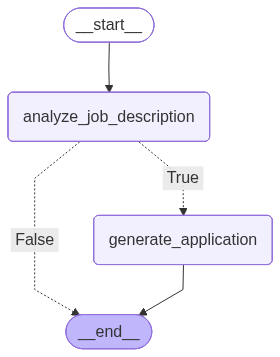

In [8]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

#### Error handling

In [9]:
from langchain_core.language_models import GenericFakeChatModel
from langchain_core.messages import AIMessage


class MessagesIterator:

    def __init__(self):
        self._count = 0

    def __iter__(self):
        return self

    def __next__(self):
        self._count += 1
        if self._count % 2 == 1:
            raise ValueError("Something went wrong")
        return AIMessage(content="YES")


fake_llm = GenericFakeChatModel(messages=MessagesIterator())

In [10]:
import logging

logger = logging.getLogger(__name__)

openai_like_llm = Config().new_openai_like()

llms = {"fake": fake_llm, "openai-like": openai_like_llm}


def analyze_job_description(state, config: RunnableConfig):
    try:
        model_provider = config["configurable"].get("model_provider", "openai-like")
        llm = llms[model_provider]
        analyze_chain = llm | parser
        prompt = prompt_template_enum.format(job_description=job_description)
        result = analyze_chain.invoke(prompt)
        return {"is_suitable": result}
    except Exception as e:
        logger.error(f"Exception {e} occurred while executing analyze_job_description")
    return {"is_suitable": False}

In [ ]:
from typing_extensions import TypedDict
from typing import Annotated, Literal
from operator import add
from langgraph.graph import StateGraph, START, END


class JobApplicationState(TypedDict):
    job_description: str
    is_suitable: bool
    application: str
    actions: Annotated[list[str], add]


def generate_application(state):
    print("...generating application...")
    return {"application": "some_fake_application", "actions": ["action2"]}


def is_suitable_condition(
    state: JobApplicationState,
) -> Literal["generate_application", END]:
    if state.get("is_suitable"):
        return "generate_application"
    return END

In [11]:
builder = StateGraph(JobApplicationState)

builder.add_node("analyze_job_description", analyze_job_description)
builder.add_node("generate_application", generate_application)

builder.add_edge(START, "analyze_job_description")
builder.add_conditional_edges("analyze_job_description", is_suitable_condition)
builder.add_edge("generate_application", END)

graph = builder.compile()

In [12]:
graph.invoke(
    {"job_description": "fake_jd"}, config={"configurable": {"model_provider": "fake"}}
)

Exception Something went wrong occurred while executing analyze_job_description
Task analyze_job_description with path ('__pregel_pull', 'analyze_job_description') wrote to unknown channel branch:to:False, ignoring it.


{'job_description': 'fake_jd', 'is_suitable': False}

In [13]:
graph.invoke(
    {"job_description": job_description},
    config={"configurable": {"model_provider": "openai-like"}},
)

Task analyze_job_description with path ('__pregel_pull', 'analyze_job_description') wrote to unknown channel branch:to:False, ignoring it.


{'job_description': '\nSPS-Software Engineer (m/w/d) im Maschinenbau\nGlaston Germany GmbH\nNeuhausen-Hamberg\nFeste Anstellung\nHomeoffice möglich, Vollzeit\nErschienen: vor 1 Tag\nGlaston Germany GmbH logo\nSPS-Software Engineer (m/w/d) im Maschinenbau\nGlaston Germany GmbH\nslide number 1slide number 2slide number 3\nGlaston ist eine internationale Marke mit weltweit führenden Unternehmen, die für zukunftsweisende Maschinen, Anlagen, Systeme und Dienstleistungen in der Bearbeitung von Architektur-, Fahrzeug- und Displayglas steht.\n\nMit unserer über 50-jährigen Erfahrung am Standort Glaston Germany GmbH in Neuhausen bei Pforzheim verbessern und sichern wir nachhaltig die Produktivität unserer Kunden bei der Fertigung von Architekturglas. Diesen Erfolg verdanken wir unseren motivierten und engagierten Mitarbeitenden und wurden so zu einem der führenden Anbieter von automatisierten und kundenspezifischen Anlagen.\n\nDer Umgang mit Software liegt dir im Blut und du möchtest bei einem 

##### Retries

In [14]:
fake_llm_retry = fake_llm.with_retry(
    retry_if_exception_type=(ValueError,),
    wait_exponential_jitter=True,
    stop_after_attempt=2,
)

analyze_chain_fake_retries = fake_llm_retry | parser

In [ ]:
from langgraph.types import RetryPolicy


def analyze_job_description(state, config: RunnableConfig):
    model_provider = config["configurable"].get("model_provider", "openai-like")
    llm = llms[model_provider]
    analyze_chain = llm | parser
    prompt = prompt_template_enum.format(job_description=job_description)
    result = analyze_chain.invoke(prompt)
    return {"is_suitable": result}


builder = StateGraph(JobApplicationState)

builder.add_node(
    "analyze_job_description",
    analyze_job_description,
    retry=RetryPolicy(retry_on=ValueError, max_attempts=2),
)
builder.add_node("generate_application", generate_application)

builder.add_edge(START, "analyze_job_description")
builder.add_conditional_edges("analyze_job_description", is_suitable_condition)
builder.add_edge("generate_application", END)

graph = builder.compile()

##### Fallbacks

In [17]:
from langchain_core.runnables import RunnableLambda

chain_fallback = RunnableLambda(lambda _: print("running fallback"))
chain = fake_llm | RunnableLambda(lambda _: print("running main chain"))
chain_with_fb = chain.with_fallbacks([chain_fallback])

chain_with_fb.invoke("test")
chain_with_fb.invoke("test")

running main chain
running fallback


## Prompt engineering

### Prompt templates

In [1]:
prompt_template = (
    "Given a job description, decide whether it suites a junior Java developer."
    "\nJOB DESCRIPTION:\n{job_description}\n"
)

In [7]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

llm = Config().new_openai_like()

lc_prompt_template = PromptTemplate.from_template(prompt_template)
chain = lc_prompt_template | llm | StrOutputParser()
chain.invoke({"job_description": job_description})

'No, this job description is **not suitable for a junior Java developer**.\n\nHere’s why:\n\n### 1. **Domain Mismatch**\n- The role is for an **SPS-Software Engineer (SPS = Speicherprogrammierbare Steuerung / Programmable Logic Controller)** in the **mechanical engineering / industrial automation** sector.\n- It focuses on **industrial control systems**, not general-purpose software development.\n- Technologies mentioned include **S7Classic, TIA Portal, Simotion**—all Siemens PLC (Programmable Logic Controller) platforms used in factory automation, **not Java-based enterprise or web applications**.\n\n### 2. **Required Experience Level**\n- The job explicitly asks for **"mehrjährige Berufserfahrung"** (several years of professional experience), especially in a **service environment** and preferably in **mechanical and plant engineering**.\n- This clearly targets **mid-level or senior professionals**, not entry-level or junior candidates.\n\n### 3. **Technical Skills Don’t Align with Ja

In [ ]:
from langchain_core.prompts import ChatPromptTemplate, HumanMessagePromptTemplate
from langchain_core.messages import SystemMessage


msg_template = HumanMessagePromptTemplate.from_template(prompt_template)

chat_prompt_template = ChatPromptTemplate.from_messages(
    [SystemMessage(content="You are a helpful assistant."), msg_template]
)
chain = chat_prompt_template | llm | StrOutputParser()

chain.invoke({"job_description": job_description})

'No, this job description is **not suitable for a junior Java developer**.\n\nHere’s why:\n\n1. **Domain Mismatch**:  \n   The role is for an **SPS-Software Engineer in mechanical engineering (Maschinenbau)**. "SPS" stands for *Speicherprogrammierbare Steuerung* (Programmable Logic Controller or PLC in English). This field involves industrial automation and control systems—not general-purpose software development like Java applications.\n\n2. **Required Technical Skills**:  \n   The job explicitly asks for **extensive knowledge in PLC programming languages** such as:\n   - S7Classic\n   - TIA Portal (Totally Integrated Automation)\n   - Simotion  \n   These are Siemens-specific industrial automation tools and are unrelated to Java development.\n\n3. **Experience Level**:  \n   The posting requires **"mehrjährige Berufserfahrung"** (several years of professional experience), especially in a service environment within mechanical engineering or plant construction. This clearly targets **m

In [9]:
chat_prompt_template = ChatPromptTemplate.from_messages(
    [("system", "You are a helpful assistant."), ("human", prompt_template)]
)
chain = chat_prompt_template | llm | StrOutputParser()

chain.invoke({"job_description": job_description})

'No, this job description is **not suitable for a junior Java developer**.\n\nHere’s why:\n\n### 1. **Domain Mismatch: Industrial Automation, Not Software Development**\n- The role is for an **SPS-Software Engineer** (SPS = *Speicherprogrammierbare Steuerung*, i.e., **Programmable Logic Controller** or **PLC**).\n- This is a **mechanical/industrial automation** role focused on **machine control systems**, not general-purpose software development.\n- The required programming languages are **PLC-specific**: S7Classic, TIA Portal, Simotion — **not Java**.\n\n### 2. **Experience Level: Senior/Experienced Required**\n- The job explicitly asks for **"mehrjährige Berufserfahrung"** (several years of professional experience), especially in the **service environment of mechanical and plant engineering**.\n- A junior developer typically has **0–2 years** of experience and would not meet this requirement.\n\n### 3. **Technical Skills Don’t Align with Java Development**\n- There is **no mention of

In [10]:
from langchain_core.prompts import ChatPromptTemplate

chat_prompt_template = ChatPromptTemplate.from_messages(
    [
        ("system", "You are a helpful assistant."),
        # same as MessagesPlaceholder("history"),
        ("placeholder", "{history}"),
        ("human", prompt_template),
    ]
)

chat_prompt_template.invoke("fake")

ChatPromptValue(messages=[SystemMessage(content='You are a helpful assistant.', additional_kwargs={}, response_metadata={}), HumanMessage(content='Given a job description, decide whether it suites a junior Java developer.\nJOB DESCRIPTION:\nfake\n', additional_kwargs={}, response_metadata={})])

In [11]:
with_history = chat_prompt_template.invoke(
    {"job_description": "fake", "history": [("human", "hi!"), ("ai", "hi!")]}
).messages

print(with_history)
len(with_history)

[SystemMessage(content='You are a helpful assistant.', additional_kwargs={}, response_metadata={}), HumanMessage(content='hi!', additional_kwargs={}, response_metadata={}), AIMessage(content='hi!', additional_kwargs={}, response_metadata={}), HumanMessage(content='Given a job description, decide whether it suites a junior Java developer.\nJOB DESCRIPTION:\nfake\n', additional_kwargs={}, response_metadata={})]


4

### Zero-shot vs. few-shot prompting

#### Chaining prompts together

In [12]:
system_template = PromptTemplate.from_template("a: {a} b: {b}")
system_template_part = system_template.partial(
    a="a"  # you also can provide a function here
)
print(system_template_part.invoke({"b": "b"}).text)

system_template_part.invoke({"b": "b"}).text == system_template_part.format(b="b")

a: a b: b


True

In [13]:
system_template_part1 = PromptTemplate.from_template("a: {a}")
system_template_part2 = PromptTemplate.from_template("b: {b}")
system_template = system_template_part1 + system_template_part2
print(system_template_part.invoke({"a": "a", "b": "b"}).text)

a: a b: b


In [14]:
system_prompt_template = PromptTemplate.from_template("a: {a} b: {b}")
chat_prompt_template = ChatPromptTemplate.from_messages(
    [("system", system_prompt_template.template), ("human", "hi"), ("ai", "{c}")]
)

messages = chat_prompt_template.invoke({"a": "a", "b": "b", "c": "c"}).messages
print(len(messages))
print(messages[0].content)

3
a: a b: b


#### Dynamic few-shot prompting

### Chain of Thought

In [15]:
from langchain import hub

math_cot_prompt = hub.pull("arietem/math_cot")
cot_chain = math_cot_prompt | llm | StrOutputParser()
print(cot_chain.invoke("Solve equation 2*x+5=15"))

We are given the equation:

$$
2x + 5 = 15
$$

### Step 1: Subtract 5 from both sides
$$
2x = 15 - 5
$$
$$
2x = 10
$$

### Step 2: Divide both sides by 2
$$
x = \frac{10}{2}
$$
$$
x = 5
$$

<answer>5</answer>


In [16]:
from operator import itemgetter
from langchain_core.prompts import PromptTemplate


parse_prompt_template = (
    "Given the initial question and a full answer, "
    "extract the concise answer. Do not assume anything and "
    "only use a provided full answer.\n\nQUESTION:\n{question}\n"
    "FULL ANSWER:\n{full_answer}\n\nCONCISE ANSWER:\n"
)
parse_prompt = PromptTemplate.from_template(parse_prompt_template)
final_chain = (
    {
        "full_answer": itemgetter("question") | cot_chain,
        "question": itemgetter("question"),
    }
    | parse_prompt
    | llm
    | StrOutputParser()
)

final_chain.invoke({"question": "Solve equation 2*x**2-96*x+1152"})

'24'

### Self-consistency

In [17]:
generations = []
for _ in range(20):
    generations.append(
        final_chain.invoke(
            {"question": "Solve equation 2*x**2-96*x+1152"}, temperature=2.0
        ).strip()
    )

from collections import Counter

Counter(generations).most_common(1)[0][0]

'24'

## Working with short context windows
### Summarizing long video

## Understanding memory mechanisms

### Trimming chat history
5 ways

1. Discard messages based on length
1. Summarize the previous conversation
1. Combine both trimming and summarization
1. Summarize long messages into a short one
1. Implement your own trimming logic

### Saving history to a database

In [1]:
from langchain_core.chat_history import InMemoryChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory
from langchain_core.language_models import FakeListChatModel
from langchain.callbacks.base import BaseCallbackHandler
from langchain_core.messages import trim_messages, HumanMessage


class PrintOutputCallback(BaseCallbackHandler):
    def on_chat_model_start(self, serialized, messages, **kwargs):
        print(f"Amount of input messages: {len(messages)}")


sessions = {}
handler = PrintOutputCallback()
llm = FakeListChatModel(responses=["ai1", "ai2", "ai3"])


def get_session_history(session_id: str):
    if session_id not in sessions:
        sessions[session_id] = InMemoryChatMessageHistory()
    return sessions[session_id]


trimmer = trim_messages(
    max_tokens=1,
    strategy="last",
    token_counter=len,
    include_system=True,
    start_on="human",
)

raw_chain = trimmer | llm
chain = RunnableWithMessageHistory(raw_chain, get_session_history)

config = {"callbacks": [PrintOutputCallback()], "configurable": {"session_id": "1"}}
_ = chain.invoke(
    [HumanMessage("Hi!")],
    config=config,
)
# print(f"History: {sessions['1'].messages}")
print(f"History length: {len(sessions['1'].messages)}")

_ = chain.invoke(
    [HumanMessage("How are you?")],
    config=config,
)
# print(f"History: {sessions['1'].messages}")
print(f"History length: {len(sessions['1'].messages)}")

Amount of input messages: 1
History length: 2
Amount of input messages: 1
History length: 4


In [2]:
sessions["1"].messages

[HumanMessage(content='Hi!', additional_kwargs={}, response_metadata={}),
 AIMessage(content='ai1', additional_kwargs={}, response_metadata={}, id='run--d6ed0ff1-1744-4f3a-8d78-c1dc11212fde-0'),
 HumanMessage(content='How are you?', additional_kwargs={}, response_metadata={}),
 AIMessage(content='ai2', additional_kwargs={}, response_metadata={}, id='run--016cf6cb-7f97-434f-a587-41d5a0cdfcfe-0')]

### LangGraph checkpoints

In [10]:
from typing import Annotated, Sequence, TypedDict

from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph
from langgraph.graph.message import add_messages


# 1. 定义状态模式，必须包含一个'messages'键
class AppState(TypedDict):
    # 使用 Annotated 和 add_messages 函数来定义消息列表的合并规则
    messages: Annotated[Sequence[BaseMessage], add_messages]


def test_node(state):
    # ignore the last message since it's an input one
    # 注意别用 state.messages 访问，否则报错。
    print(f"History length = {len(state['messages'][:-1])}")
    # return [AIMessage(content="Hello!")]
    return {"messages": [AIMessage(content="Hello!")]}


builder = StateGraph(AppState)

builder.add_node("test_node", test_node)

builder.add_edge(START, "test_node")
builder.add_edge("test_node", END)

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

In [11]:
_ = graph.invoke(
    {"messages": [HumanMessage(content="test")]},
    config={"configurable": {"thread_id": "thread-a"}},
)
_ = graph.invoke(
    {"messages": [HumanMessage(content="test")]},
    config={"configurable": {"thread_id": "thread-b"}},
)
_ = graph.invoke(
    {"messages": [HumanMessage(content="test")]},
    config={"configurable": {"thread_id": "thread-a"}},
)

History length = 0
History length = 0
History length = 2


In [12]:
checkpoints = list(memory.list(config={"configurable": {"thread_id": "thread-a"}}))

for check_point in checkpoints:
    print(check_point.config["configurable"]["checkpoint_id"])

1f0b3d4a-585a-6215-8004-32d076f92337
1f0b3d4a-5858-67b6-8003-83f117e18dce
1f0b3d4a-5857-64f5-8002-362f07c5559c
1f0b3d4a-584f-6796-8001-d14b4b0c774f
1f0b3d4a-584c-68ae-8000-3bbe984e921a
1f0b3d4a-584a-6297-bfff-8a8e7da461ed


In [ ]:
checkpoints = list(memory.list(config={"configurable": {"thread_id": "thread-a"}}))

for check_point in checkpoints:
    print(check_point.config["configurable"]["checkpoint_id"])

In [6]:
checkpoint_id = checkpoints[-1].config["configurable"]["checkpoint_id"]
_ = graph.invoke(
    {"messages": [HumanMessage(content="test")]},
    config={"configurable": {"thread_id": "thread-a", "checkpoint_id": checkpoint_id}},
)

History length = 0


In [7]:
checkpoint_id = checkpoints[-3].config["configurable"]["checkpoint_id"]
_ = graph.invoke(
    {"messages": [HumanMessage(content="test")]},
    config={"configurable": {"thread_id": "thread-a", "checkpoint_id": checkpoint_id}},
)

History length = 2
